# $f_{1}^{´}$
# Different candidates for different target functions?

- calculate some statistics for the characteristic values and their relation to SMCF and statistical quality parameters **(ToDo)**

In [10]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
import pandas as pd

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict

from empir19nrm02 import _SPD, _RES

print('Version of luxpy:', lx.__version__)
out_dir = 'Met2'

Version of luxpy: v1.10.0
Version of luxpy: v1.10.0


# What about other target functions?

**$V^{'}(\lambda)$** is already included in the CMF list (cieobs='1951_20_scotopic')

To add:
- **BLH** (from the photobiochem toolbox of luxpy to the _CMF)
- **$s_{\mathrm{mel}}$** (from the photobiochem toolbox ipRGC to the _CMF)

BLH


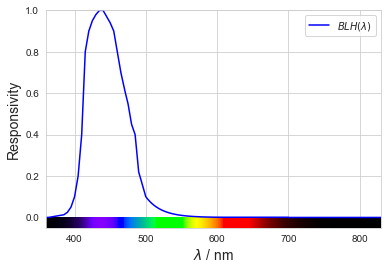

SMEL


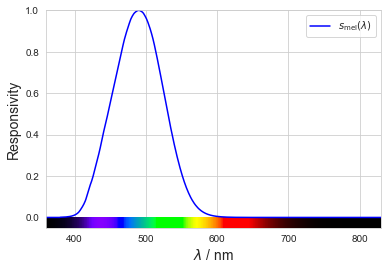

In [11]:
if 'BLH'  not in _CMF['types']:
    print( 'BLH')
    add_to_cmf_dict(bar=np.vstack((_BLH,_BLH[1],_BLH[1])), cieobs = 'BLH', K = 683, M = np.eye(3))
    plot_cmf2( name='BLH', cmf_symbols=['BLH'], cmf_colors = ['b-'],  single=True)
    save_fig( out_dir, 'BLH_function')

if 'SMEL'  not in _CMF['types']:
    print( 'SMEL')
    add_to_cmf_dict(bar=np.vstack((_ACTIONSPECTRA_CIES026[0],_ACTIONSPECTRA_CIES026[5],_ACTIONSPECTRA_CIES026[5],_ACTIONSPECTRA_CIES026[5])), cieobs = 'SMEL', K = 683*Km_correction_factor, M = np.eye(3))
    plot_cmf2( name='SMEL', cmf_symbols=['s_{\mathrm{mel}}'], cmf_colors = ['b-'],  single=True)
    save_fig( out_dir, 'SMEL_function')

# What we need to evaluated/calculate:

- Detectors --> _detectors
- Target functions --> _target_name **and** index
- Spectral distributions --> _spectra
- SMCF's evaluated for the combination of Detectors/target function and SD depending on the calibration
- Characteristic values to be evaluated for the detectors --> cValues
- Evaluation of the connection between the cValues and the SMCF values


In [12]:
dCutOff = 0.003

def calc_cValues( detectors, target_name = '1931_2', target_index=2):
    f1pA=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pE=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pLED=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pAFMin=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    f1pp=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=dCutOff, dBandWidth=0.)
    f1ppR=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='E', iMin=0, dCutOff=-dCutOff, dBandWidth=0.)
    f1pBW20nm=py_f1PrimeGlx(detectors, strObserver=target_name, iObserverOffset = target_index-1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=20.)

    return f1pA, f1pE, f1pLED, f1pAFMin, f1pp, f1ppR, f1pBW20nm

In [13]:
def makeLinearRegression( _xdata, _ydata):
    lr_model = LinearRegression()
    xdata = _xdata.copy()
    nonZeros =np.where(_xdata != 0)
    xdata= xdata.reshape(-1,1)
    lr_model.fit(xdata, _ydata)
    slope=lr_model.coef_[0]
    offset=lr_model.intercept_
    r_sq = lr_model.score(xdata, _ydata)

    # without the first data set (normally zero)
    smcfSlopeMax = np.zeros(xdata.shape[0])
    smcfSlopeMax[nonZeros]=_ydata[nonZeros]/_xdata[nonZeros]
    smcfSlopeQMax = np.quantile( smcfSlopeMax, 1-quantil)

    print( slope, offset, r_sq, smcfSlopeQMax)
    return slope, offset, r_sq, smcfSlopeQMax

# Sensitivity for wavelength dependent noise

In [14]:
def eval_target_noise( target, str_target, name):
    _detectorsNoise = target.copy()

    for i in range(0, target.shape[1]):
        to_add = target.copy()
        to_add[1,i] += .1
        _detectorsNoise= np.vstack((_detectorsNoise, to_add[1]))

    fig, ax1 = pyplot.subplots()
    ax1.plot(_detectorsNoise[0], _detectorsNoise[1], 'g-', label=str_target)
    ax1.plot(_detectorsNoise[0], _detectorsNoise[4], '*', label=str_target +'$ + \Delta$')
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel('Signal' + strd['AU'], fontsize=label_font_size)
    ax1.set_xlim([380, 500])
    ax1.set_ylim([0, 0.2])
    pyplot.legend()
    save_fig(out_dir, name + 'noiseSingle')


    nf1pA, nf1pE, nf1pLED, nf1pAFMin, nf1pp, nf1ppR, nf1pBW20nm = \
        calc_cValues(_detectorsNoise, _target_name, _target_index)

    nsubPlot = 2

    xRange = np.arange(375,780+1,5)
    fig, ax1 = pyplot.subplots()
    ax2 = ax1.twinx()

    ax1.plot(xRange[1::nsubPlot], nf1pA[1::nsubPlot], '-', label=strd['f1p'])
    ax1.plot(xRange[1::nsubPlot], nf1pE[1::nsubPlot], 'x', label=strd['f1pE'])
    ax1.plot(xRange[1::nsubPlot], nf1pLED[1::nsubPlot], '--', label=strd['f1pLED'])
    ax1.plot(xRange[1::nsubPlot], nf1pAFMin[1::nsubPlot], '<', label=strd['f1pMin'])
    ax1.plot(xRange[1::nsubPlot], nf1ppR[1::nsubPlot], '>', label=strd['f1ppR'])
    ax1.plot(xRange[1::nsubPlot], nf1pBW20nm[1::nsubPlot], '2', label=strd['f1pBW'])
    ax2.plot(xRange[1::nsubPlot], nf1pp[1::nsubPlot], '1', label=strd['f1pp'])

    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel(strd['f1p'] + ',' + strd['f1pE'] + ',' +  strd['f1pMin'] + ',' +  strd['f1ppR'] + ',' +  strd['f1pBW'], fontsize=label_font_size)
    ax2.set_ylabel(strd['f1pp'], fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.3, 1, 0), loc='lower left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'noiseEval')

# Sensitivity for correlated wavelength shifts

In [15]:
def eval_target_shift( target, str_target, name):
    _detectorsShift = target.copy()

    shift2min = 0
    shift2max = 5
    shift_steps = 0.1
    shift_range = np.arange(shift2min, shift2max+2*shift_steps, shift_steps)

    for i in shift_range:
        wl_current = _detectors[0]+i
        target_moved = np.vstack((wl_current, target[1]))
        target_interpolated = lx.cie_interp(target_moved, target[0], negative_values_allowed=True, kind='linear')
        _detectorsShift = np.vstack((_detectorsShift, target_interpolated[1]))

    detectors_shift_number = _detectorsShift.shape[0]
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[2,:], 'r-', label='shift ' + str(shift2min)+ ' nm')
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[int((detectors_shift_number-1)/2),:], 'g-', label=str_target)
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[detectors_shift_number-1,:], 'b-', label='shift +' + str(shift2max)+ ' nm')
    pyplot.xlabel(strd['xlambda'], fontsize=label_font_size)
    pyplot.ylabel(str_target + ',' + strd['srelLambda'], fontsize=label_font_size)
    pyplot.legend()
    save_fig(out_dir, name + 'ShiftsSingle')

    sf1pA, sf1pE, sf1pLED, sf1pAFMin, sf1pp, sf1ppR, sf1pBW20nm = \
        calc_cValues(_detectorsShift, _target_name, _target_index)

    fig, ax1 = pyplot.subplots()
    ax2 = ax1.twinx()

    xRange = shift_range
    subPlot = 5
    ax1.plot(xRange[1::subPlot], sf1pA[1::subPlot], '-', label=strd['f1p'])
    ax1.plot(xRange[1::subPlot], sf1pE[1::subPlot], 'x', label=strd['f1pE'])
    ax1.plot(xRange[1::subPlot], sf1pLED[1::subPlot], '--', label=strd['f1pLED'])
    ax1.plot(xRange[1::subPlot], sf1pAFMin[1::subPlot], '<', label=strd['f1pMin'])
    ax1.plot(xRange[1::subPlot], sf1ppR[1::subPlot], '>', label=strd['f1ppR'])
    ax1.plot(xRange[1::subPlot], sf1pBW20nm[1::subPlot], '2', label=strd['f1pBW'])
    ax2.plot(xRange[1::subPlot], sf1pp[1::subPlot], '1', label=strd['f1pp'])

    ax1.set_xlabel('$\Delta\lambda$ / nm', fontsize=label_font_size)
    ax1.set_ylabel(strd['f1p'] + ',' + strd['f1pE'] + ',' +  strd['f1pMin'] + ',' +  strd['f1ppR'] + ',' +  strd['f1pBW'], fontsize=label_font_size)
    ax2.set_ylabel(strd['f1pp'], fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.2, 1, 0), loc='upper left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'ShiftsEval')
    return  np.array([0, sf1pA[-1],sf1pE[-1],sf1pLED[-1],sf1pAFMin[-1],sf1ppR[-1],sf1pBW20nm[-1]])/float(shift2max)

In [16]:
def display_spectra( spd, _spectra, out_dir=None):
    # plot the mean value with some statistical data
    s_number = _spectra.shape[0]-1
    print( s_number)
    for i in range(2,s_number,int(s_number/10)):
        print(i)
        pyplot.plot(_spectra[0], _spectra[i]/np.max(_spectra[i]))
    pyplot.ylabel(strd['SDLambda'],fontsize=label_font_size)
    pyplot.xlabel(strd['xlambda'],fontsize=label_font_size)

    if out_dir is not None:
        save_fig( out_dir, spd+'_SPDSamples')

    # Horseshoo missing
    if out_dir is not None:
        save_fig( out_dir, spd+'_xy')

VLDetectors


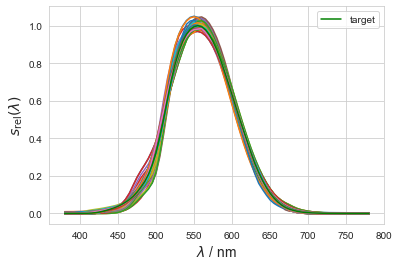

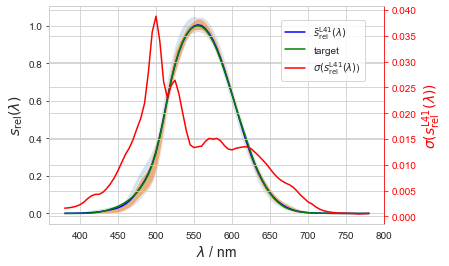

[0.0000e+00 1.9892e-02 4.4345e-02 7.9305e-02 1.7255e-02 1.7928e-02
 2.0011e-02 1.8447e-02 6.0041e-02 5.9719e-02 7.2566e-02 2.5503e-02
 1.4335e-02 2.5905e-02 2.2364e-02 1.3590e-02 1.4515e-02 1.4051e-02
 1.2648e-02 1.3225e-02 1.2950e-02 1.7794e-02 1.9129e-02 1.8503e-02
 1.5062e-02 1.6188e-02 1.5655e-02 1.5217e-02 1.5394e-02 1.5183e-02
 1.9654e-02 4.1588e-02 2.9768e-02 3.5193e-02 3.0304e-02 3.8384e-02
 3.8195e-02 2.3439e-02 3.6651e-02 3.2774e-02 1.8559e-02 3.7134e-02
 4.2127e-02 4.5884e-02 8.3396e-02 4.4570e-02 2.7668e-02 5.2109e-02
 4.1464e-02 5.9534e-02 5.8230e-02 4.3879e-02 5.1698e-02 1.9548e-02
 6.2325e-02 8.4231e-02 2.5858e-02 6.5862e-02 7.3820e-02 2.6893e-02
 8.0095e-02 8.8773e-02 7.3608e-02 2.3819e-02 5.7351e-03 7.3046e-03
 1.8704e-02 2.1492e-02 2.9875e-02 3.0776e-02 6.1675e-02 6.0032e-02
 5.9715e-02 7.2587e-02 2.5501e-02 1.4157e-02 2.5901e-02 2.2364e-02
 1.8817e-02 1.9935e-02 1.9930e-02 2.0570e-02 2.0829e-02 2.0531e-02
 2.1059e-02 2.1455e-02 2.1051e-02 2.1735e-02 2.1363e-02 2.1669

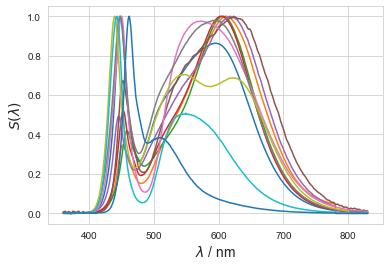

<Figure size 432x288 with 0 Axes>

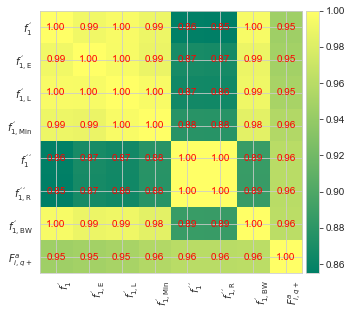

$f_{1}^{´}$
0.2604809631093875 -0.0012552115079667268 0.8938564078455156 0.301011692998443
$f_{1,\mathrm{E}}^{´}$
0.2550398845723978 -0.0012097908913102284 0.8985446267576859 0.28401535276280143
$f_{1,\mathrm{L}}^{´}$
0.2722107439211861 -0.0015131364288802386 0.9029295705843396 0.29365077970270087
$f_{1,\mathrm{Min}}^{´}$
0.2902184275067653 -0.0016569220191808877 0.9140511003856374 0.3171781124091887
$f_{1,\mathrm{R}}^{´´}$
0.3314403567005117 0.0011295740318909356 0.921130150590769 0.9312198476653181
$f_{1,\mathrm{BW}}^{´}$
0.2714065582586053 -0.0007423637412177714 0.9237340966264191 0.3095507905304856


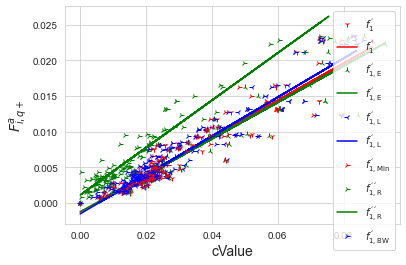

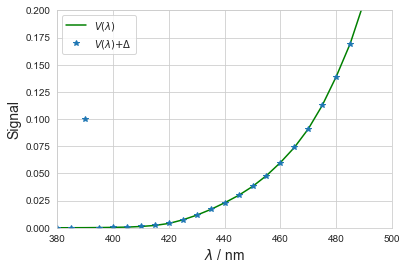

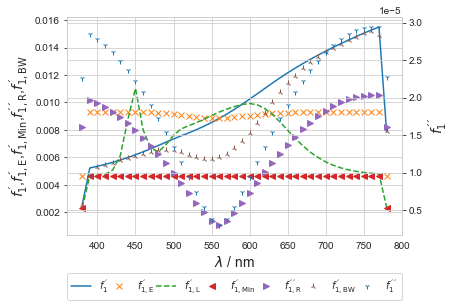

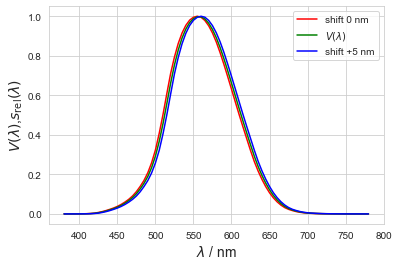

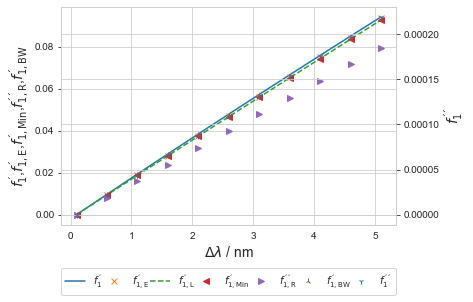

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)


   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   

   shift [1/nm]  
0      0.019207  
0      0.019089  
0      0.018913  
0      0.018886  
0      0.016223  
0      0.018916  
XDetectors


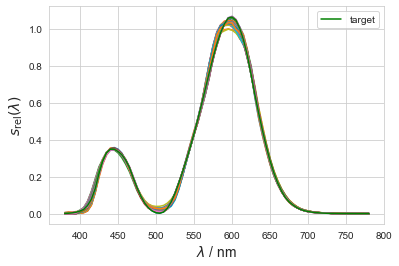

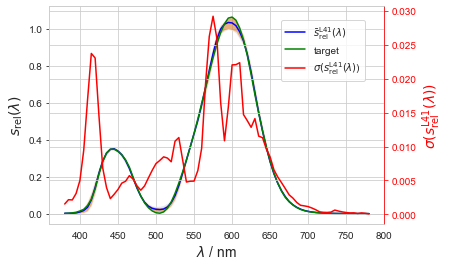

[4.0279e-07 4.6475e-02 3.6214e-02 3.8050e-02 3.7328e-02 3.9067e-02
 3.9621e-02 4.1052e-02 5.0117e-02 3.9913e-02 3.0391e-02 3.3855e-02
 4.3979e-02 3.3693e-02 3.1888e-02 3.0635e-02 3.0851e-02 2.8535e-02
 3.1285e-02 3.3651e-02 3.1627e-02 3.0915e-02 1.1936e-02 1.0980e-02
 1.0880e-02 1.1019e-02 1.0613e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


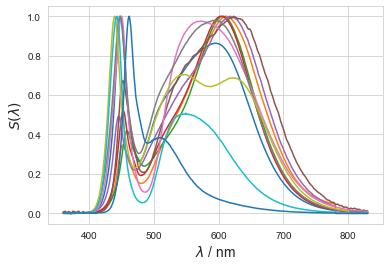

<Figure size 432x288 with 0 Axes>

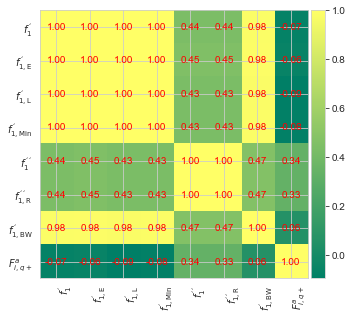

$f_{1}^{´}$
-0.010619328188209584 0.11114645839415879 0.00490345857786767 10.44264501482924
$f_{1,\mathrm{E}}^{´}$
-0.008758695821574453 0.11109104516714863 0.0033226278360667383 10.418521224092842
$f_{1,\mathrm{L}}^{´}$
-0.014114702267754598 0.11125309186613622 0.008733289707662628 10.477270937067855
$f_{1,\mathrm{Min}}^{´}$
-0.012919141317329423 0.11121309607027507 0.0071718024799444224 10.511905649287735
$f_{1,\mathrm{R}}^{´´}$
0.11208700038301972 0.10985563775581982 0.11191562200884941 55.010969745775654
$f_{1,\mathrm{BW}}^{´}$
0.011685796955690471 0.11056170756012464 0.004151729156850137 18.89834875510742


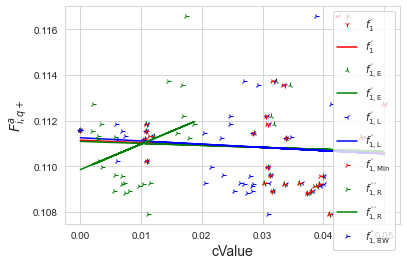

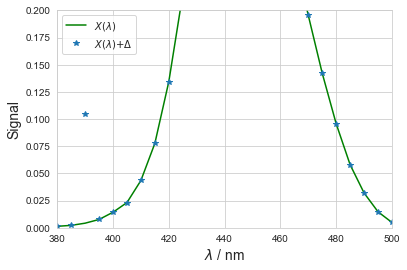

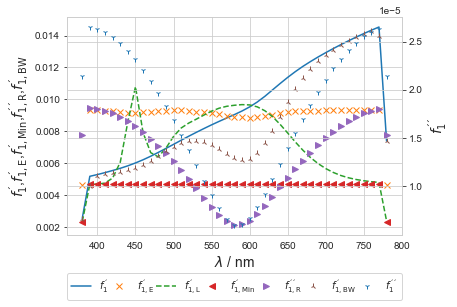

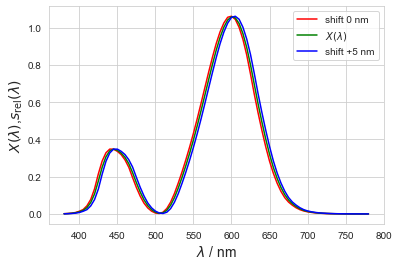

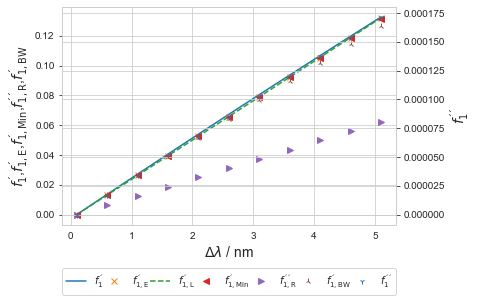

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

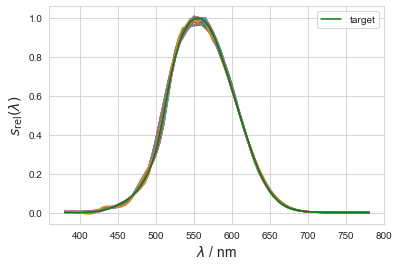

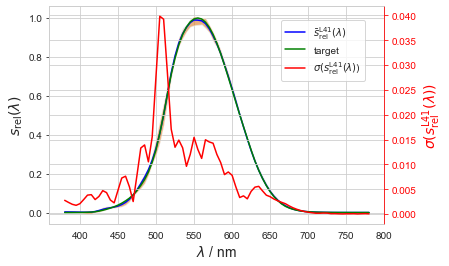

[0.0000e+00 3.2784e-02 2.2070e-02 2.1332e-02 2.1262e-02 2.5198e-02
 2.6587e-02 2.5145e-02 2.9574e-02 2.2676e-02 2.4612e-02 2.2251e-02
 3.6829e-02 3.3852e-02 3.1918e-02 3.0365e-02 3.1313e-02 3.1210e-02
 2.2501e-02 2.2689e-02 2.3784e-02 2.7327e-02 7.5231e-03 8.1952e-03
 7.4113e-03 8.3398e-03 7.9245e-03]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


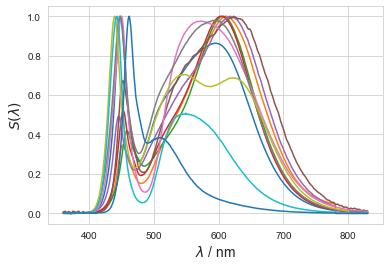

<Figure size 432x288 with 0 Axes>

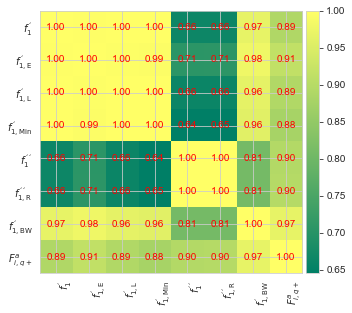

$f_{1}^{´}$
0.22108647325430328 -0.0010167675116716356 0.7916269763631396 0.23504241742475612
$f_{1,\mathrm{E}}^{´}$
0.2167020221654431 -0.0010486357263948167 0.8343528792566501 0.22027661947819857
$f_{1,\mathrm{L}}^{´}$
0.22264956258704827 -0.0010550955936492112 0.7948643863937249 0.23863431369331817
$f_{1,\mathrm{Min}}^{´}$
0.22401853600310634 -0.0009794421577966964 0.7704807160260752 0.24834809383756176
$f_{1,\mathrm{R}}^{´´}$
0.39281599638298903 0.0012094086146024175 0.8030178629664977 1.3273512317293987
$f_{1,\mathrm{BW}}^{´}$
0.26184659198190413 -0.0006553568489413176 0.9338335667031838 0.2627917223211964


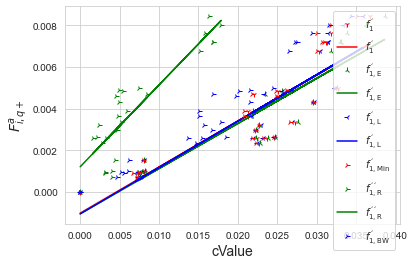

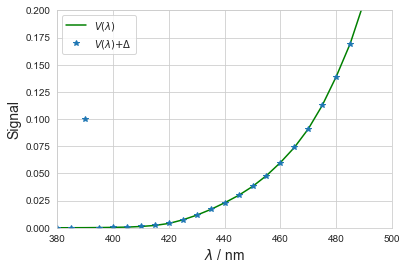

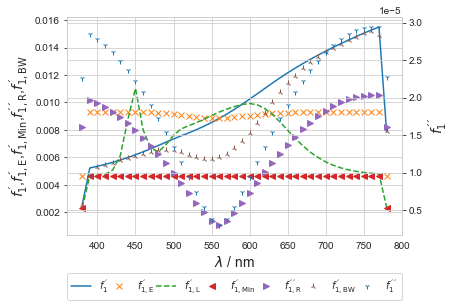

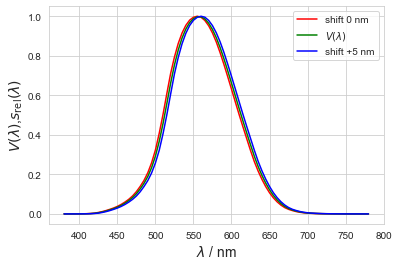

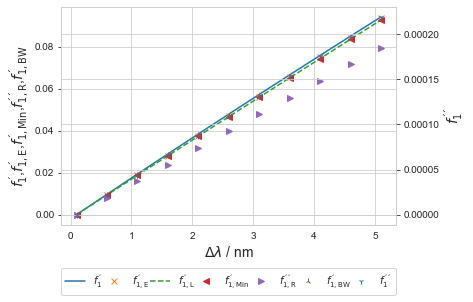

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

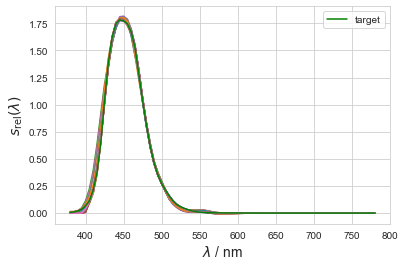

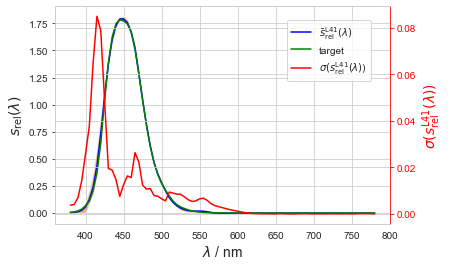

[2.4322e-12 2.7408e-02 2.4510e-02 2.4638e-02 2.7551e-02 2.1452e-02
 2.1966e-02 2.1445e-02 2.4163e-02 2.8351e-02 2.5515e-02 2.4951e-02
 7.0998e-02 6.0804e-02 6.1764e-02 5.5268e-02 5.6484e-02 5.4493e-02
 1.9811e-02 2.2649e-02 2.4050e-02 3.7207e-02 1.8671e-02 2.0420e-02
 1.9229e-02 2.1217e-02 1.7124e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


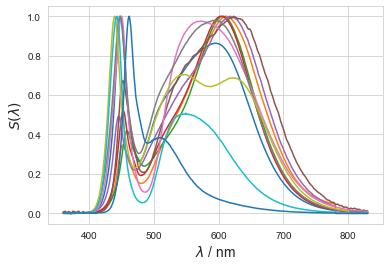

<Figure size 432x288 with 0 Axes>

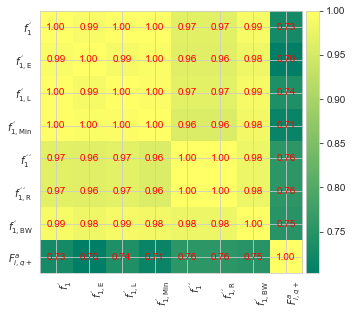

$f_{1}^{´}$
0.5519519500697819 1.311564912209916 0.5302658233348514 76.02318200349839
$f_{1,\mathrm{E}}^{´}$
0.45423751167423365 1.3138538576091165 0.49409383894225145 73.0146012854988
$f_{1,\mathrm{L}}^{´}$
0.5344992109516425 1.311834238185712 0.5460064609377873 77.2654344420608
$f_{1,\mathrm{Min}}^{´}$
0.5737329810840328 1.3114172230433514 0.5103302623062547 77.81446575304399
$f_{1,\mathrm{R}}^{´´}$
0.8771921812842902 1.3180629686045426 0.5703250321649955 519.5613498830564
$f_{1,\mathrm{BW}}^{´}$
0.6393939180974368 1.3145147134707222 0.5640705107794309 140.03792494968832


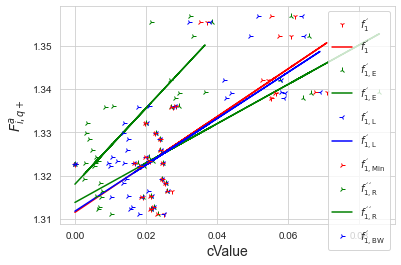

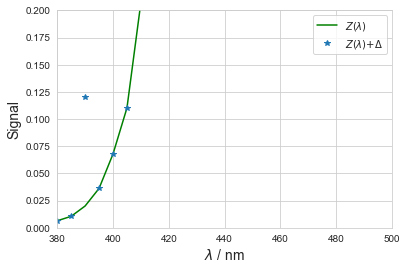

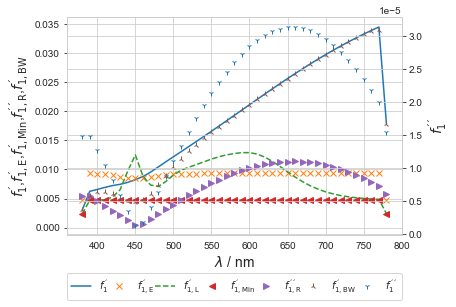

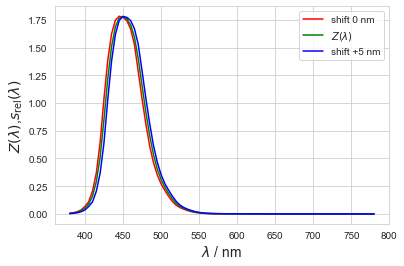

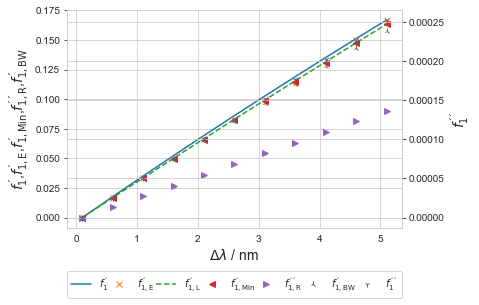

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

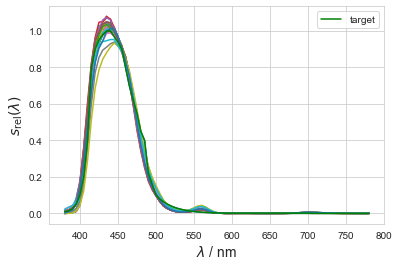

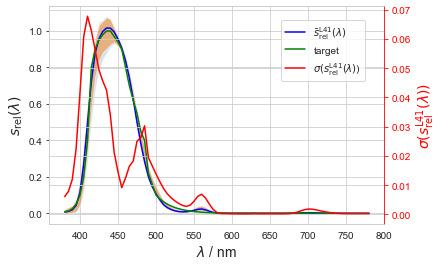

[8.9680e-03 8.5042e-02 8.2824e-02 8.7456e-02 1.1118e-01 1.0474e-01
 8.5512e-02 9.2104e-02 9.4175e-02 1.0753e-01 8.8273e-02 8.8304e-02
 8.2661e-02 1.2911e-01 1.0221e-01 9.5848e-02 9.1041e-02 9.9635e-02
 9.6961e-02 7.9685e-02 9.5421e-02 9.1934e-02 9.0015e-02 1.1263e-01
 1.1271e-01 9.9794e-02 6.4995e-02 1.0739e-01 1.4758e-01 7.7852e-02
 9.1710e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


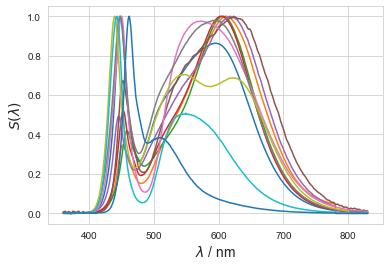

<Figure size 432x288 with 0 Axes>

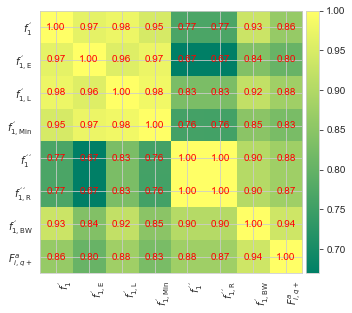

$f_{1}^{´}$
0.44903350831640015 -0.017960643840174935 0.7458629610349425 0.3697237297682121
$f_{1,\mathrm{E}}^{´}$
0.435660990056881 -0.013713917236732535 0.6468483434913452 0.3957564746471568
$f_{1,\mathrm{L}}^{´}$
0.44214760298222167 -0.014762353558847731 0.769323005342954 0.38280823641211575
$f_{1,\mathrm{Min}}^{´}$
0.45457022989665263 -0.012703857060413257 0.6820211400364429 0.41434575859583134
$f_{1,\mathrm{R}}^{´´}$
0.5226117690285458 0.007705192919701103 0.7653317267072246 2.141203246406078
$f_{1,\mathrm{BW}}^{´}$
0.4364313977187436 -0.007300833960022152 0.8770242584565018 0.4528972507786009


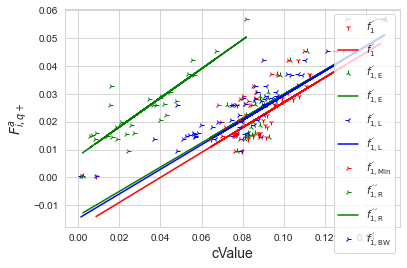

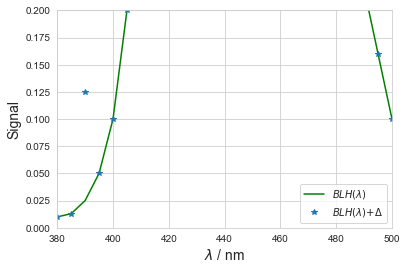

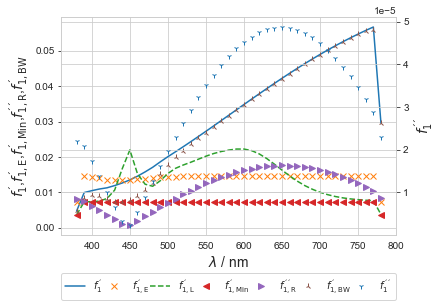

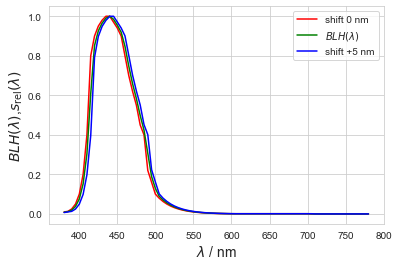

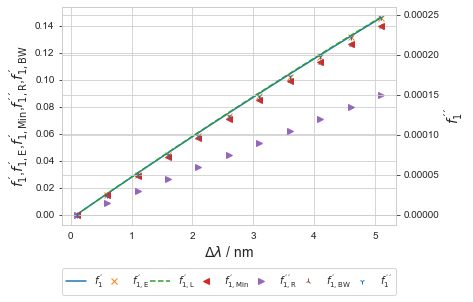

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N          Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1    $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2    $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3    $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4    $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5    $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6    $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1    $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2    $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3    $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4    $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5    $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6    $X(\lambda)$  f1pBW20nm  0.01168

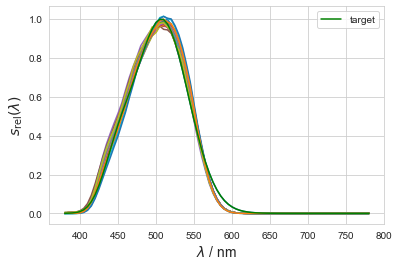

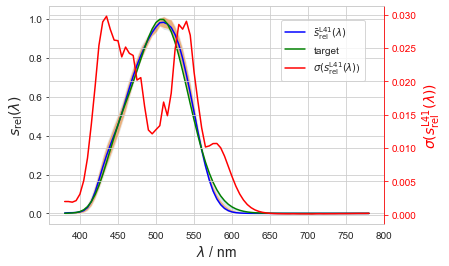

[7.9323e-11 6.6469e-02 6.4924e-02 7.0900e-02 9.6092e-02 8.8954e-02
 6.3658e-02 6.7268e-02 6.7839e-02 7.3677e-02 6.1266e-02 5.9708e-02
 6.2745e-02 6.1999e-02 6.0868e-02 5.8198e-02 6.4712e-02 6.6618e-02
 8.0780e-02 7.5088e-02 8.7120e-02 6.3243e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


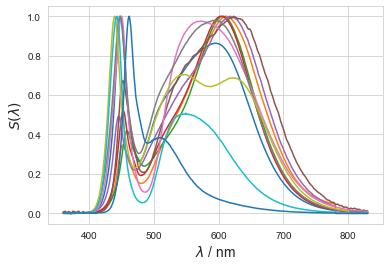

<Figure size 432x288 with 0 Axes>

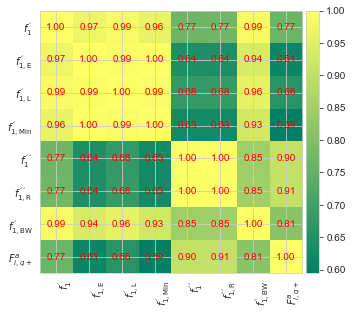

$f_{1}^{´}$
0.3759074694723024 -0.0038362669866739488 0.5853077529774191 0.41409879798402827
$f_{1,\mathrm{E}}^{´}$
0.3252785449348282 0.0011746721056573976 0.3766071330359009 0.5038232809179553
$f_{1,\mathrm{L}}^{´}$
0.3508167666925858 -0.001082735826736611 0.4358108900554868 0.4672945063594177
$f_{1,\mathrm{Min}}^{´}$
0.3171115900784933 0.001939169810334887 0.35301881519913536 0.5159654104705503
$f_{1,\mathrm{R}}^{´´}$
0.4669974578300974 0.007590851096037824 0.8204877609245682 1.1869921677294824
$f_{1,\mathrm{BW}}^{´}$
0.404470086849603 -0.002820365081384932 0.6562478373469209 0.4389377185898155


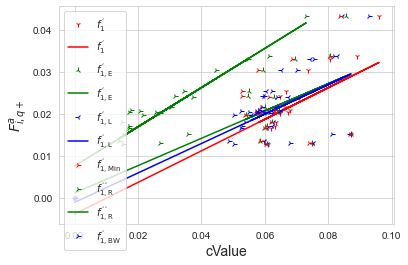

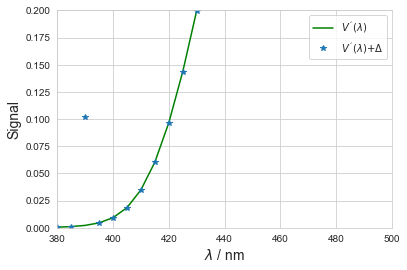

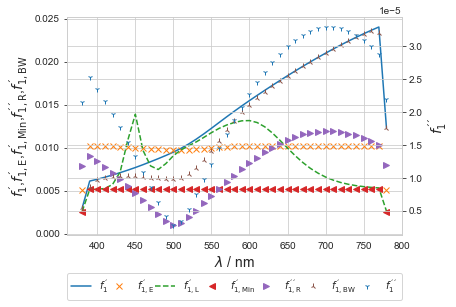

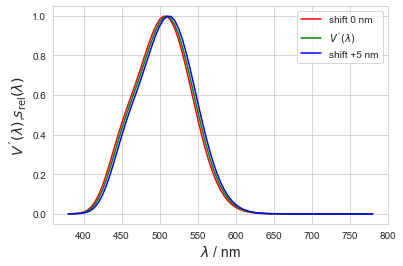

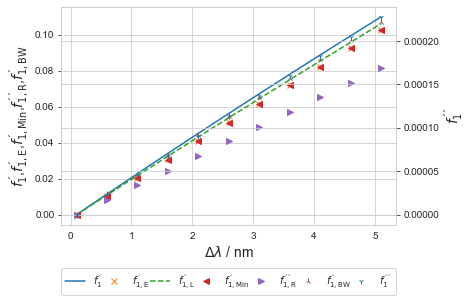

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N            Target       Name     m_q95     n_q95  r_sq_q95  \
0  1      $V(\lambda)$        f1p  0.260481 -0.001255  0.893856   
0  2      $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545   
0  3      $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930   
0  4      $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051   
0  5      $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130   
0  6      $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734   
0  1      $X(\lambda)$        f1p -0.010619  0.111146  0.004903   
0  2      $X(\lambda)$       f1pE -0.008759  0.111091  0.003323   
0  3      $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733   
0  4      $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172   
0  5      $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916   
0  6      $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152   
0  1      $V(\lambda)$        f1p  0.221086 -0.001017  0.791627   
0  2      $V(\lambda)$       f1pE  0.216702 -0.001049  0.83435

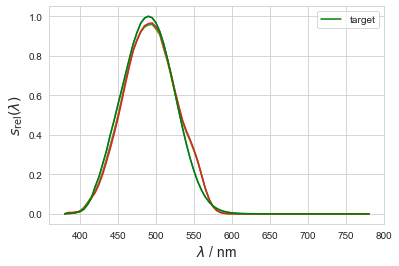

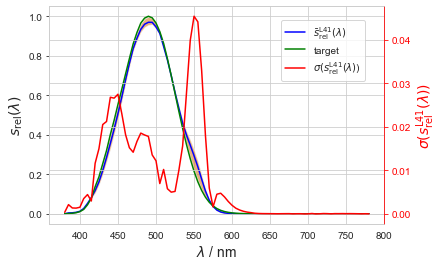

[1.0294e-05 8.3158e-02 8.9911e-02 9.4632e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


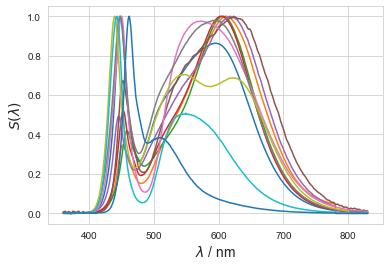

<Figure size 432x288 with 0 Axes>

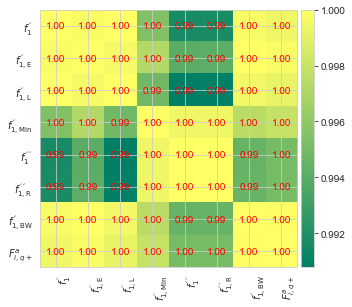

$f_{1}^{´}$
0.4020926064356938 -9.622573378424704e-05 0.9988910559087287 0.4068566750828994
$f_{1,\mathrm{E}}^{´}$
0.484739309230487 -4.80774871130657e-05 0.9996372847345955 0.4879973704910547
$f_{1,\mathrm{L}}^{´}$
0.4497462702346855 -0.00010697374350807087 0.9984029095184309 0.4564457781818444
$f_{1,\mathrm{Min}}^{´}$
0.5152461691076865 0.0003249856904727448 0.995781451325526 0.5377018972570223
$f_{1,\mathrm{R}}^{´´}$
0.7247110156525243 0.000586136457089128 0.9902638117300444 0.7773756261824154
$f_{1,\mathrm{BW}}^{´}$
0.4281801357772085 -3.4052823672872656e-05 0.9998258366820291 0.43028276097039764


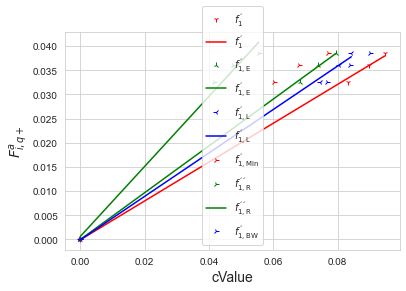

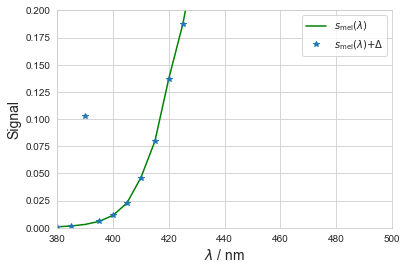

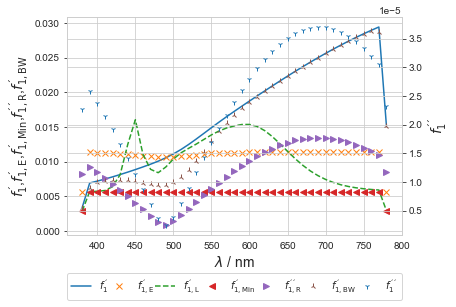

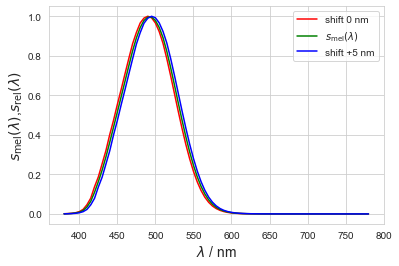

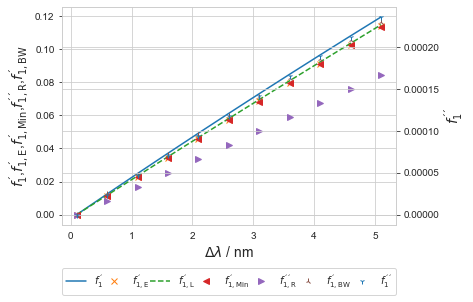

   N                       Target       Name     m_q95     n_q95  r_sq_q95  \
0  1                 $V(\lambda)$        f1p  0.260481 -0.001255  0.893856   
0  2                 $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545   
0  3                 $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930   
0  4                 $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051   
0  5                 $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130   
0  6                 $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734   
0  1                 $X(\lambda)$        f1p -0.010619  0.111146  0.004903   
0  2                 $X(\lambda)$       f1pE -0.008759  0.111091  0.003323   
0  3                 $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733   
0  4                 $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172   
0  5                 $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916   
0  6                 $X(\lambda)$  f1pBW20nm  0.011686  0.110562

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

VLDetectors


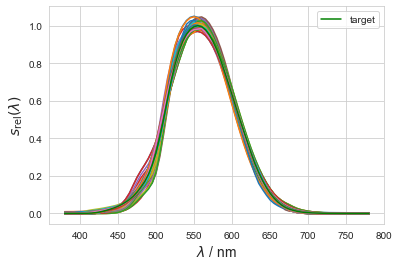

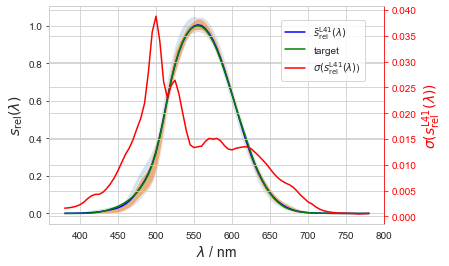

[0.0000e+00 1.9892e-02 4.4345e-02 7.9305e-02 1.7255e-02 1.7928e-02
 2.0011e-02 1.8447e-02 6.0041e-02 5.9719e-02 7.2566e-02 2.5503e-02
 1.4335e-02 2.5905e-02 2.2364e-02 1.3590e-02 1.4515e-02 1.4051e-02
 1.2648e-02 1.3225e-02 1.2950e-02 1.7794e-02 1.9129e-02 1.8503e-02
 1.5062e-02 1.6188e-02 1.5655e-02 1.5217e-02 1.5394e-02 1.5183e-02
 1.9654e-02 4.1588e-02 2.9768e-02 3.5193e-02 3.0304e-02 3.8384e-02
 3.8195e-02 2.3439e-02 3.6651e-02 3.2774e-02 1.8559e-02 3.7134e-02
 4.2127e-02 4.5884e-02 8.3396e-02 4.4570e-02 2.7668e-02 5.2109e-02
 4.1464e-02 5.9534e-02 5.8230e-02 4.3879e-02 5.1698e-02 1.9548e-02
 6.2325e-02 8.4231e-02 2.5858e-02 6.5862e-02 7.3820e-02 2.6893e-02
 8.0095e-02 8.8773e-02 7.3608e-02 2.3819e-02 5.7351e-03 7.3046e-03
 1.8704e-02 2.1492e-02 2.9875e-02 3.0776e-02 6.1675e-02 6.0032e-02
 5.9715e-02 7.2587e-02 2.5501e-02 1.4157e-02 2.5901e-02 2.2364e-02
 1.8817e-02 1.9935e-02 1.9930e-02 2.0570e-02 2.0829e-02 2.0531e-02
 2.1059e-02 2.1455e-02 2.1051e-02 2.1735e-02 2.1363e-02 2.1669

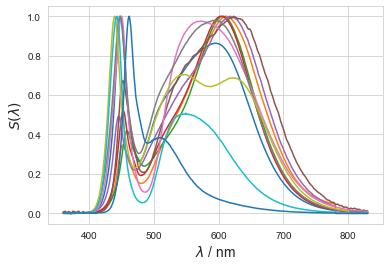

<Figure size 432x288 with 0 Axes>

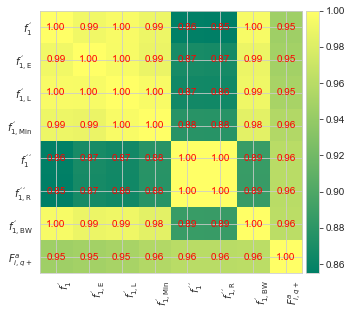

$f_{1}^{´}$
0.2604809631093875 -0.0012552115079667268 0.8938564078455156 0.301011692998443
$f_{1,\mathrm{E}}^{´}$
0.2550398845723978 -0.0012097908913102284 0.8985446267576859 0.28401535276280143
$f_{1,\mathrm{L}}^{´}$
0.2722107439211861 -0.0015131364288802386 0.9029295705843396 0.29365077970270087
$f_{1,\mathrm{Min}}^{´}$
0.2902184275067653 -0.0016569220191808877 0.9140511003856374 0.3171781124091887
$f_{1,\mathrm{R}}^{´´}$
0.3314403567005117 0.0011295740318909356 0.921130150590769 0.9312198476653181
$f_{1,\mathrm{BW}}^{´}$
0.2714065582586053 -0.0007423637412177714 0.9237340966264191 0.3095507905304856


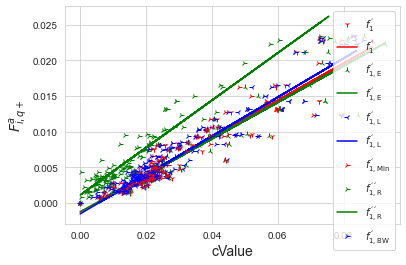

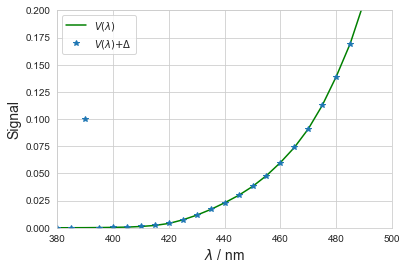

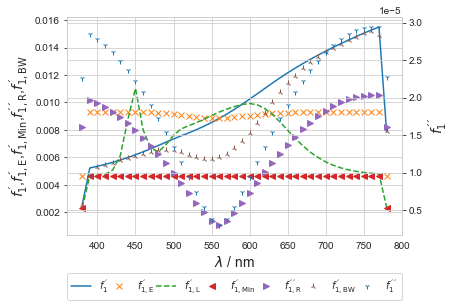

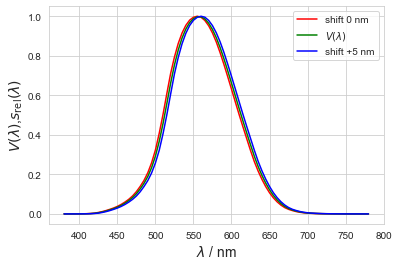

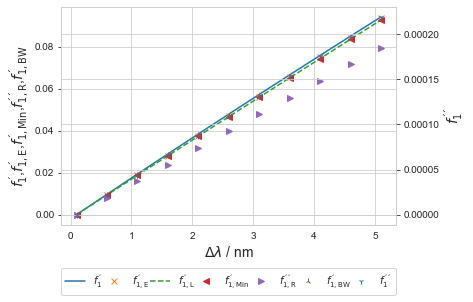

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)


   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   

   shift [1/nm]  
0      0.019207  
0      0.019089  
0      0.018913  
0      0.018886  
0      0.016223  
0      0.018916  
XDetectors


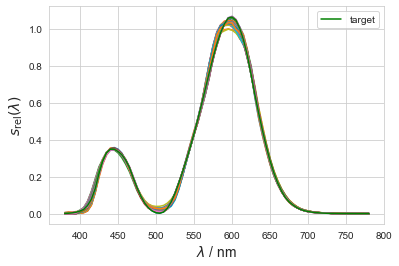

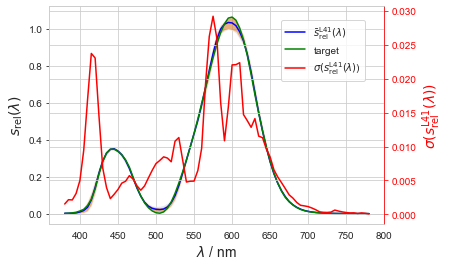

[4.0279e-07 4.6475e-02 3.6214e-02 3.8050e-02 3.7328e-02 3.9067e-02
 3.9621e-02 4.1052e-02 5.0117e-02 3.9913e-02 3.0391e-02 3.3855e-02
 4.3979e-02 3.3693e-02 3.1888e-02 3.0635e-02 3.0851e-02 2.8535e-02
 3.1285e-02 3.3651e-02 3.1627e-02 3.0915e-02 1.1936e-02 1.0980e-02
 1.0880e-02 1.1019e-02 1.0613e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


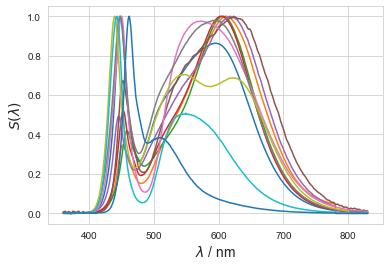

<Figure size 432x288 with 0 Axes>

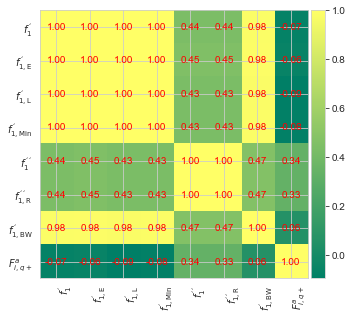

$f_{1}^{´}$
-0.010619328188209584 0.11114645839415879 0.00490345857786767 10.44264501482924
$f_{1,\mathrm{E}}^{´}$
-0.008758695821574453 0.11109104516714863 0.0033226278360667383 10.418521224092842
$f_{1,\mathrm{L}}^{´}$
-0.014114702267754598 0.11125309186613622 0.008733289707662628 10.477270937067855
$f_{1,\mathrm{Min}}^{´}$
-0.012919141317329423 0.11121309607027507 0.0071718024799444224 10.511905649287735
$f_{1,\mathrm{R}}^{´´}$
0.11208700038301972 0.10985563775581982 0.11191562200884941 55.010969745775654
$f_{1,\mathrm{BW}}^{´}$
0.011685796955690471 0.11056170756012464 0.004151729156850137 18.89834875510742


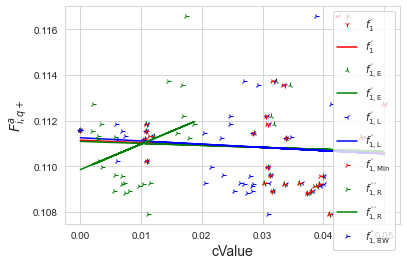

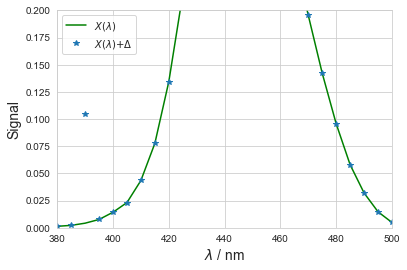

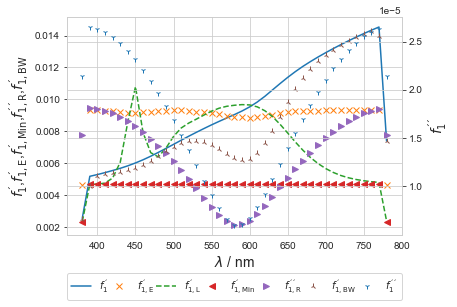

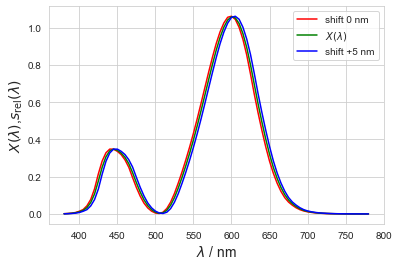

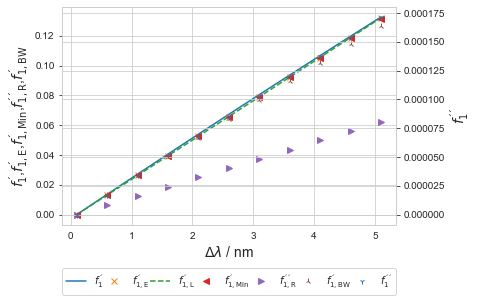

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

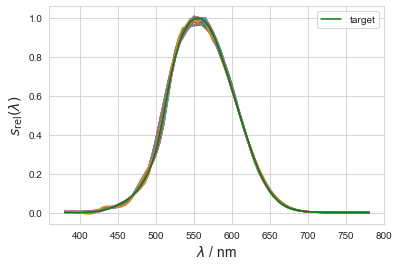

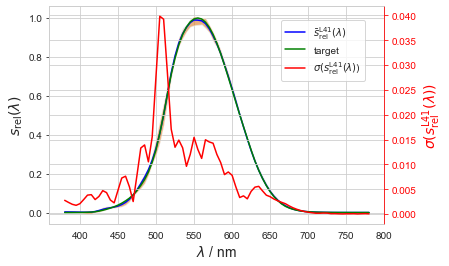

[0.0000e+00 3.2784e-02 2.2070e-02 2.1332e-02 2.1262e-02 2.5198e-02
 2.6587e-02 2.5145e-02 2.9574e-02 2.2676e-02 2.4612e-02 2.2251e-02
 3.6829e-02 3.3852e-02 3.1918e-02 3.0365e-02 3.1313e-02 3.1210e-02
 2.2501e-02 2.2689e-02 2.3784e-02 2.7327e-02 7.5231e-03 8.1952e-03
 7.4113e-03 8.3398e-03 7.9245e-03]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


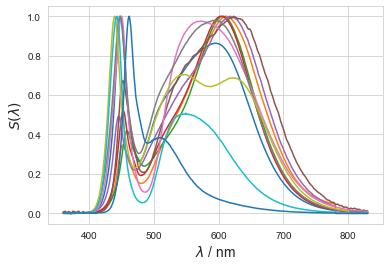

<Figure size 432x288 with 0 Axes>

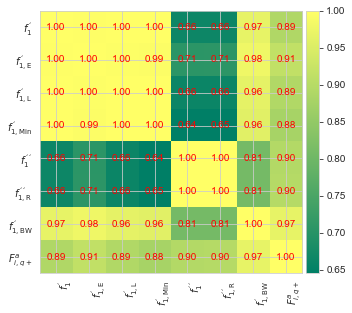

$f_{1}^{´}$
0.22108647325430328 -0.0010167675116716356 0.7916269763631396 0.23504241742475612
$f_{1,\mathrm{E}}^{´}$
0.2167020221654431 -0.0010486357263948167 0.8343528792566501 0.22027661947819857
$f_{1,\mathrm{L}}^{´}$
0.22264956258704827 -0.0010550955936492112 0.7948643863937249 0.23863431369331817
$f_{1,\mathrm{Min}}^{´}$
0.22401853600310634 -0.0009794421577966964 0.7704807160260752 0.24834809383756176
$f_{1,\mathrm{R}}^{´´}$
0.39281599638298903 0.0012094086146024175 0.8030178629664977 1.3273512317293987
$f_{1,\mathrm{BW}}^{´}$
0.26184659198190413 -0.0006553568489413176 0.9338335667031838 0.2627917223211964


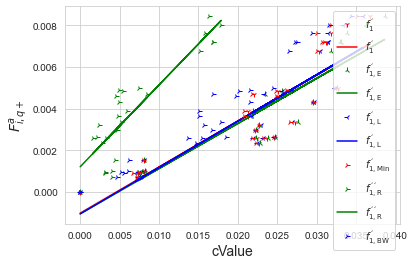

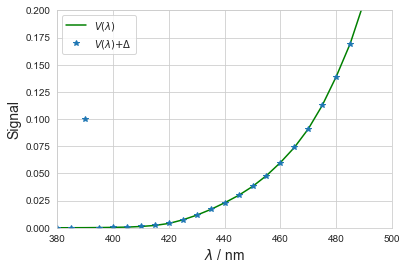

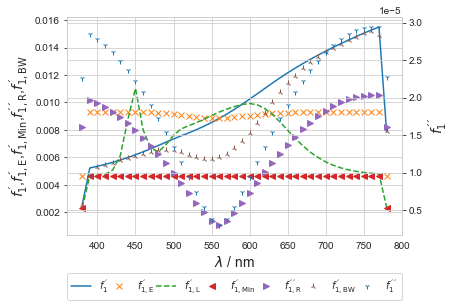

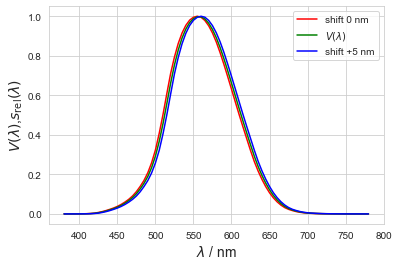

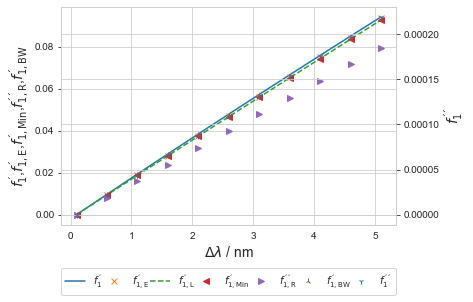

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

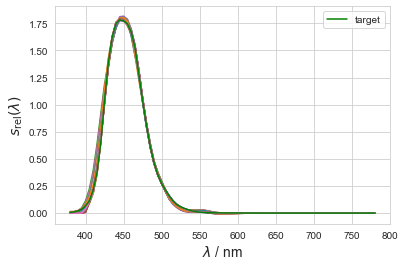

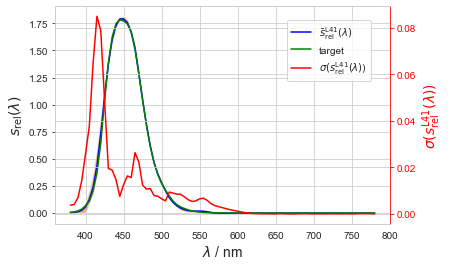

[2.4322e-12 2.7408e-02 2.4510e-02 2.4638e-02 2.7551e-02 2.1452e-02
 2.1966e-02 2.1445e-02 2.4163e-02 2.8351e-02 2.5515e-02 2.4951e-02
 7.0998e-02 6.0804e-02 6.1764e-02 5.5268e-02 5.6484e-02 5.4493e-02
 1.9811e-02 2.2649e-02 2.4050e-02 3.7207e-02 1.8671e-02 2.0420e-02
 1.9229e-02 2.1217e-02 1.7124e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


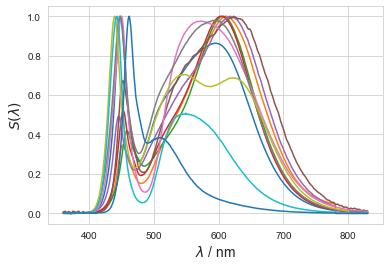

<Figure size 432x288 with 0 Axes>

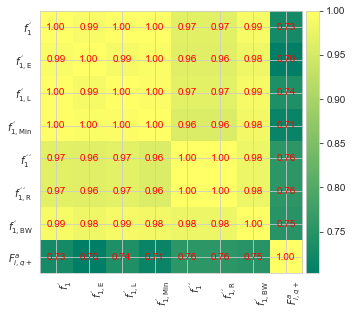

$f_{1}^{´}$
0.5519519500697819 1.311564912209916 0.5302658233348514 76.02318200349839
$f_{1,\mathrm{E}}^{´}$
0.45423751167423365 1.3138538576091165 0.49409383894225145 73.0146012854988
$f_{1,\mathrm{L}}^{´}$
0.5344992109516425 1.311834238185712 0.5460064609377873 77.2654344420608
$f_{1,\mathrm{Min}}^{´}$
0.5737329810840328 1.3114172230433514 0.5103302623062547 77.81446575304399
$f_{1,\mathrm{R}}^{´´}$
0.8771921812842902 1.3180629686045426 0.5703250321649955 519.5613498830564
$f_{1,\mathrm{BW}}^{´}$
0.6393939180974368 1.3145147134707222 0.5640705107794309 140.03792494968832


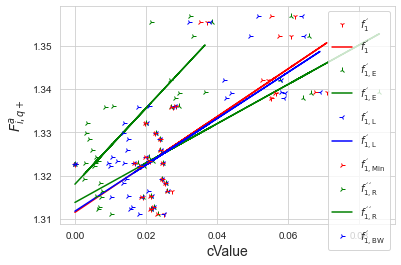

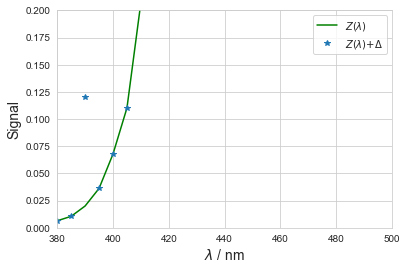

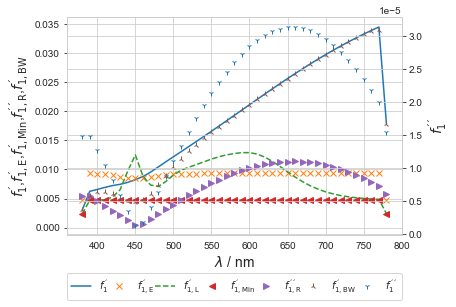

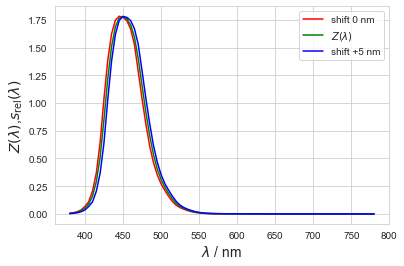

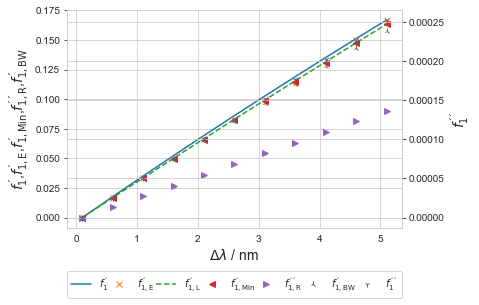

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N        Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1  $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2  $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3  $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4  $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5  $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6  $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1  $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2  $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3  $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4  $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5  $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6  $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152     

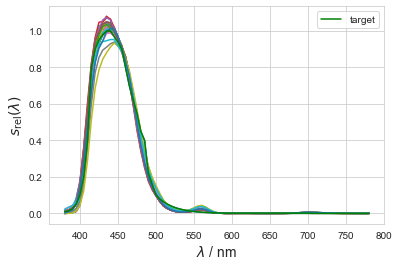

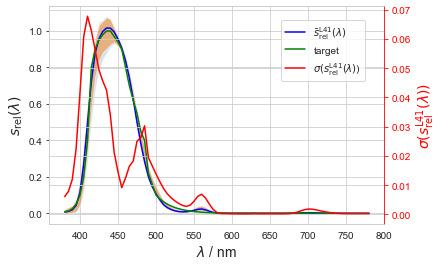

[8.9680e-03 8.5042e-02 8.2824e-02 8.7456e-02 1.1118e-01 1.0474e-01
 8.5512e-02 9.2104e-02 9.4175e-02 1.0753e-01 8.8273e-02 8.8304e-02
 8.2661e-02 1.2911e-01 1.0221e-01 9.5848e-02 9.1041e-02 9.9635e-02
 9.6961e-02 7.9685e-02 9.5421e-02 9.1934e-02 9.0015e-02 1.1263e-01
 1.1271e-01 9.9794e-02 6.4995e-02 1.0739e-01 1.4758e-01 7.7852e-02
 9.1710e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


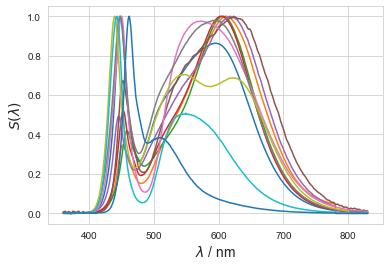

<Figure size 432x288 with 0 Axes>

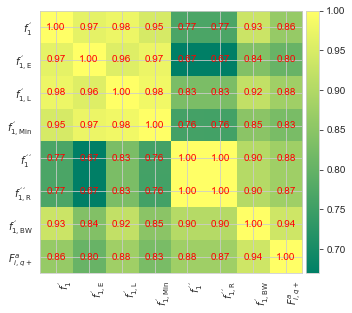

$f_{1}^{´}$
0.44903350831640015 -0.017960643840174935 0.7458629610349425 0.3697237297682121
$f_{1,\mathrm{E}}^{´}$
0.435660990056881 -0.013713917236732535 0.6468483434913452 0.3957564746471568
$f_{1,\mathrm{L}}^{´}$
0.44214760298222167 -0.014762353558847731 0.769323005342954 0.38280823641211575
$f_{1,\mathrm{Min}}^{´}$
0.45457022989665263 -0.012703857060413257 0.6820211400364429 0.41434575859583134
$f_{1,\mathrm{R}}^{´´}$
0.5226117690285458 0.007705192919701103 0.7653317267072246 2.141203246406078
$f_{1,\mathrm{BW}}^{´}$
0.4364313977187436 -0.007300833960022152 0.8770242584565018 0.4528972507786009


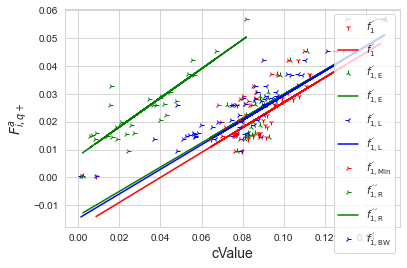

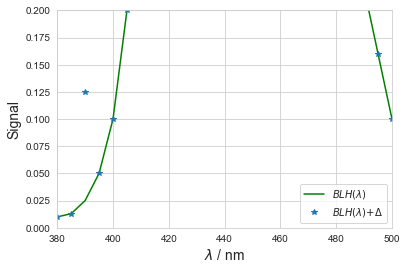

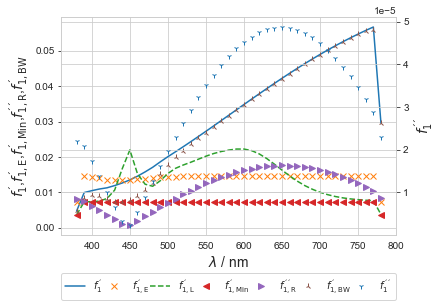

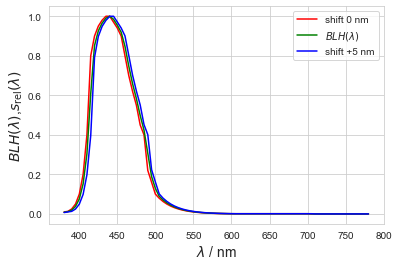

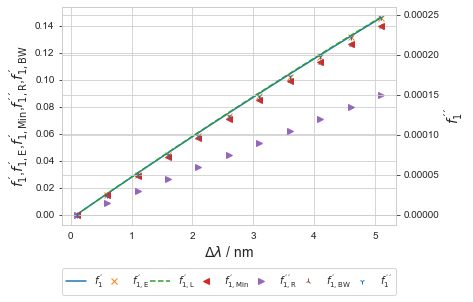

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N          Target       Name     m_q95     n_q95  r_sq_q95  smcfSlopeQMax  \
0  1    $V(\lambda)$        f1p  0.260481 -0.001255  0.893856       0.301012   
0  2    $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545       0.284015   
0  3    $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930       0.293651   
0  4    $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051       0.317178   
0  5    $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130       0.931220   
0  6    $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734       0.309551   
0  1    $X(\lambda)$        f1p -0.010619  0.111146  0.004903      10.442645   
0  2    $X(\lambda)$       f1pE -0.008759  0.111091  0.003323      10.418521   
0  3    $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733      10.477271   
0  4    $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172      10.511906   
0  5    $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916      55.010970   
0  6    $X(\lambda)$  f1pBW20nm  0.01168

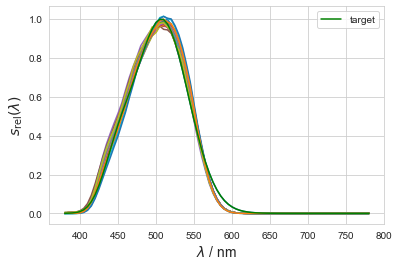

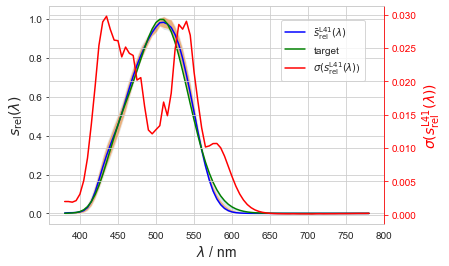

[7.9323e-11 6.6469e-02 6.4924e-02 7.0900e-02 9.6092e-02 8.8954e-02
 6.3658e-02 6.7268e-02 6.7839e-02 7.3677e-02 6.1266e-02 5.9708e-02
 6.2745e-02 6.1999e-02 6.0868e-02 5.8198e-02 6.4712e-02 6.6618e-02
 8.0780e-02 7.5088e-02 8.7120e-02 6.3243e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


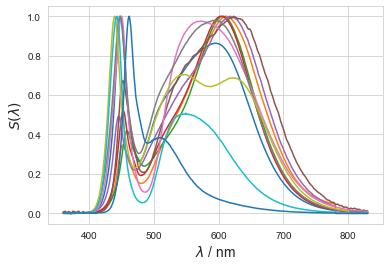

<Figure size 432x288 with 0 Axes>

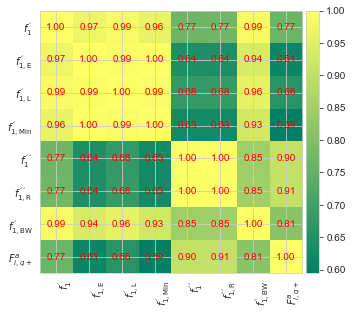

$f_{1}^{´}$
0.3759074694723024 -0.0038362669866739488 0.5853077529774191 0.41409879798402827
$f_{1,\mathrm{E}}^{´}$
0.3252785449348282 0.0011746721056573976 0.3766071330359009 0.5038232809179553
$f_{1,\mathrm{L}}^{´}$
0.3508167666925858 -0.001082735826736611 0.4358108900554868 0.4672945063594177
$f_{1,\mathrm{Min}}^{´}$
0.3171115900784933 0.001939169810334887 0.35301881519913536 0.5159654104705503
$f_{1,\mathrm{R}}^{´´}$
0.4669974578300974 0.007590851096037824 0.8204877609245682 1.1869921677294824
$f_{1,\mathrm{BW}}^{´}$
0.404470086849603 -0.002820365081384932 0.6562478373469209 0.4389377185898155


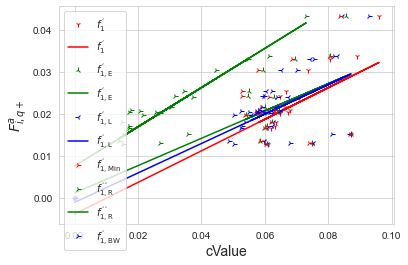

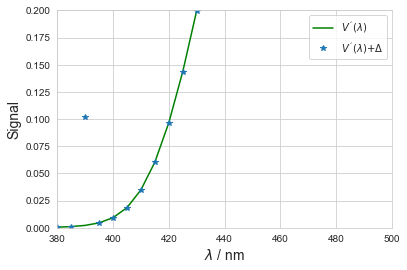

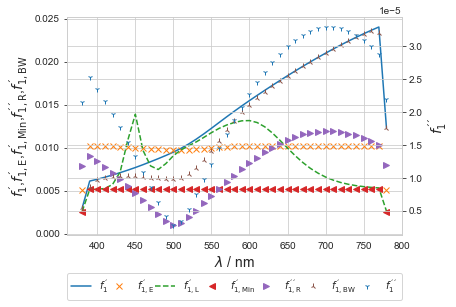

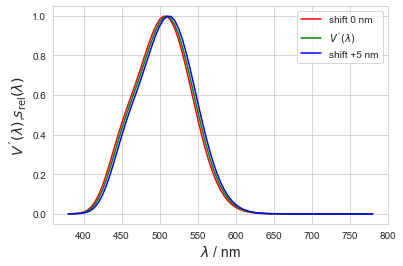

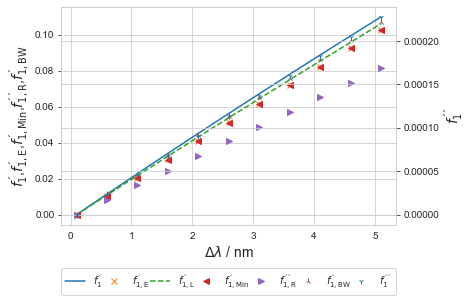

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

   N            Target       Name     m_q95     n_q95  r_sq_q95  \
0  1      $V(\lambda)$        f1p  0.260481 -0.001255  0.893856   
0  2      $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545   
0  3      $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930   
0  4      $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051   
0  5      $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130   
0  6      $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734   
0  1      $X(\lambda)$        f1p -0.010619  0.111146  0.004903   
0  2      $X(\lambda)$       f1pE -0.008759  0.111091  0.003323   
0  3      $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733   
0  4      $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172   
0  5      $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916   
0  6      $X(\lambda)$  f1pBW20nm  0.011686  0.110562  0.004152   
0  1      $V(\lambda)$        f1p  0.221086 -0.001017  0.791627   
0  2      $V(\lambda)$       f1pE  0.216702 -0.001049  0.83435

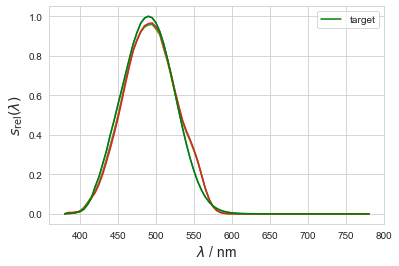

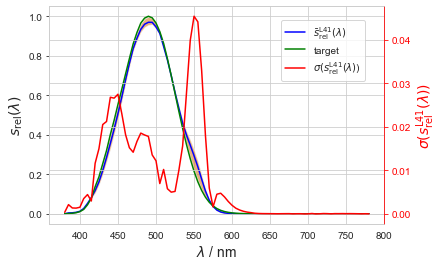

[1.0294e-05 8.3158e-02 8.9911e-02 9.4632e-02]
1496
2
151
300
449
598
747
896
1045
1194
1343
1492


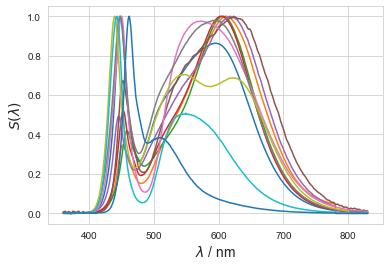

<Figure size 432x288 with 0 Axes>

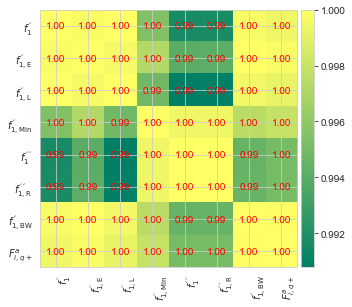

$f_{1}^{´}$
0.4020926064356938 -9.622573378424704e-05 0.9988910559087287 0.4068566750828994
$f_{1,\mathrm{E}}^{´}$
0.484739309230487 -4.80774871130657e-05 0.9996372847345955 0.4879973704910547
$f_{1,\mathrm{L}}^{´}$
0.4497462702346855 -0.00010697374350807087 0.9984029095184309 0.4564457781818444
$f_{1,\mathrm{Min}}^{´}$
0.5152461691076865 0.0003249856904727448 0.995781451325526 0.5377018972570223
$f_{1,\mathrm{R}}^{´´}$
0.7247110156525243 0.000586136457089128 0.9902638117300444 0.7773756261824154
$f_{1,\mathrm{BW}}^{´}$
0.4281801357772085 -3.4052823672872656e-05 0.9998258366820291 0.43028276097039764


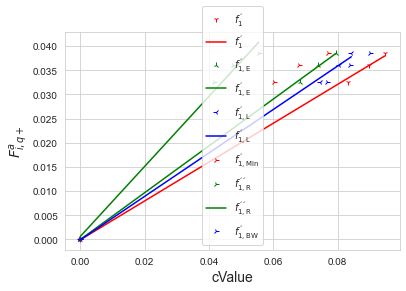

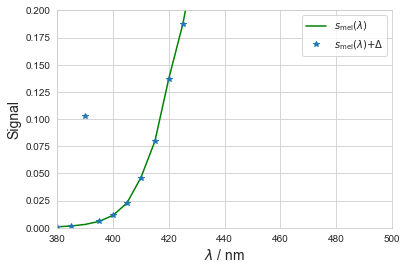

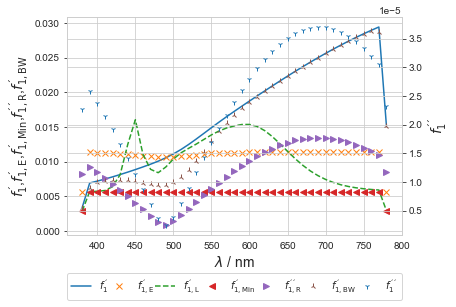

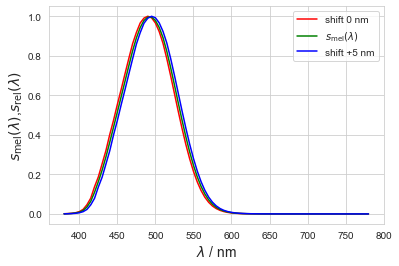

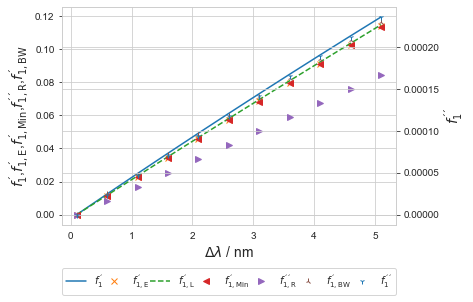

   N                       Target       Name     m_q95     n_q95  r_sq_q95  \
0  1                 $V(\lambda)$        f1p  0.260481 -0.001255  0.893856   
0  2                 $V(\lambda)$       f1pE  0.255040 -0.001210  0.898545   
0  3                 $V(\lambda)$     f1pLED  0.272211 -0.001513  0.902930   
0  4                 $V(\lambda)$     f1pMin  0.290218 -0.001657  0.914051   
0  5                 $V(\lambda)$      f1ppR  0.331440  0.001130  0.921130   
0  6                 $V(\lambda)$  f1pBW20nm  0.271407 -0.000742  0.923734   
0  1                 $X(\lambda)$        f1p -0.010619  0.111146  0.004903   
0  2                 $X(\lambda)$       f1pE -0.008759  0.111091  0.003323   
0  3                 $X(\lambda)$     f1pLED -0.014115  0.111253  0.008733   
0  4                 $X(\lambda)$     f1pMin -0.012919  0.111213  0.007172   
0  5                 $X(\lambda)$      f1ppR  0.112087  0.109856  0.111916   
0  6                 $X(\lambda)$  f1pBW20nm  0.011686  0.110562

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_5864\3635312597.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1pTable = f1pTable.append( df)
C:\Users\udo.krueger\AppData\Local\T

In [17]:
_DETECTOR_TYPES = ['VLDetectors','XDetectors','YDetectors','ZDetectors','BLHDetectors','VSDetectors','SMELDetectors']
_TARGET_NAMES = ['1931_2','1931_2','1931_2','1931_2','BLH','VS','SMEL']
_TARGET_INDEX = [2,1,2,3,2,2,2]

strNames=['', 'f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
f1pTable = pd.DataFrame()

for i, detector_type in enumerate(_DETECTOR_TYPES): # store all in single nested dict
#for i in range(0,2):
    _name = _DETECTOR_TYPES[i]
    _target_name = _TARGET_NAMES[i]
    _target_index = _TARGET_INDEX[i]
    S_C = 'LED_L41' # 'A'
    spd = 'PHOTOLED' # 'BB, 'PHOTOLED', 'MONOLED'

    str_target = ''
    if _target_name == '1931_2':
        if _target_index == 1:
            str_target = '$X(\lambda)$'
        elif _target_index == 2:
            str_target = '$V(\lambda)$'
        elif _target_index == 3:
            str_target = '$Z(\lambda)$'
    else:
        if _target_name == 'BLH':
            str_target = '$BLH(\lambda)$'
        if _target_name == 'VS':
            str_target = '$V^{´}(\lambda)$'
            _target_name = '1951_20_scotopic'
        if _target_name == 'SMEL':
            str_target = '$s_{\mathrm{mel}}(\lambda)$'

    _detectors=_RES[_name]['S']['data'].copy()
    display_responsivity(_name, _detectors, cieobs=_target_name, s_target_index=_target_index, out_dir=out_dir)

    _spectra=_SPD[spd]['S']['data'].copy()
    display_spectra( spd, _spectra, out_dir=out_dir)

    _SMCF=np.abs(1.-lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
        _spectra, _detectors, S_C=S_C, cieobs=_target_name))

    c_f1pA, c_f1pE, c_f1pLED, c_f1pAFMin, c_f1pp, c_f1ppR, c_f1pBW20nm = calc_cValues(_detectors, _target_name, _target_index)

    qPlus=np.quantile( _SMCF, 1-quantil, axis=0)

    # Correlations between the index values

    # Combine the results in a vector
    f1pEval = np.vstack(( c_f1pA, c_f1pE, c_f1pLED, c_f1pAFMin, c_f1pp, c_f1ppR, c_f1pBW20nm, qPlus))
    f1pEvalCorr = np.corrcoef(f1pEval)
    x_label_list = [ strd['f1p'], strd['f1pE'], strd['f1pLED'], strd['f1pMin'], strd['f1pp'], strd['f1ppR'], strd['f1pBW'], strd['q_plus_a']]
    plotCorrMatrixSmall(f1pEvalCorr, x_label_list, title=None, fileName=None, with_values=True)
    save_fig(out_dir, _name + 'corr')

    print( strd['f1p'])
    s_f1pA=makeLinearRegression( c_f1pA, qPlus)
    print( strd['f1pE'])
    s_f1pE=makeLinearRegression( c_f1pE, qPlus)
    print( strd['f1pLED'])
    s_f1pLED=makeLinearRegression( c_f1pLED, qPlus)
    print( strd['f1pMin'])
    s_f1pAFMin=makeLinearRegression( c_f1pAFMin, qPlus)
    print( strd['f1ppR'])
    s_f1ppR=makeLinearRegression( c_f1ppR, qPlus)
    print( strd['f1pBW'])
    s_f1pBW20nm=makeLinearRegression( c_f1pBW20nm, qPlus)
    data=[s_f1pA, s_f1pA, s_f1pE, s_f1pLED, s_f1pAFMin, s_f1ppR, s_f1pBW20nm]

    fig, ax = pyplot.subplots()
    ax.set_xlabel('cValue', fontsize=label_font_size)
    ax.set_ylabel(strd['q_plus_a'], fontsize=label_font_size)
    ax.plot( c_f1pA, qPlus, 'r1', label=strd['f1p'])
    ax.plot( c_f1pA, s_f1pA[0]*c_f1pA + s_f1pA[1], 'r-', label=strd['f1p'])
    ax.plot( c_f1pE, qPlus, 'g2', label=strd['f1pE'])
    ax.plot( c_f1pE, s_f1pE[0]*c_f1pE + s_f1pE[1], 'g-', label=strd['f1pE'])
    ax.plot( c_f1pLED, qPlus, 'b3', label=strd['f1pLED'])
    ax.plot( c_f1pLED,s_f1pLED[0]* c_f1pLED+s_f1pLED[1], 'b-', label=strd['f1pLED'])
    ax.plot( c_f1pAFMin, qPlus, 'r4', label=strd['f1pMin'])
    ax.plot( c_f1ppR, qPlus, 'g4', label=strd['f1ppR'])
    ax.plot( c_f1ppR, s_f1ppR[0]*c_f1ppR+s_f1ppR[1], 'g-', label=strd['f1ppR'])
    ax.plot( c_f1pBW20nm, qPlus, 'b4', label=strd['f1pBW'])
    ax.legend()
    save_fig(out_dir, _name + 'cValueReg')

    # target funciton in the right resolution
    target = get_target(cieobs=_target_name, target_index=_target_index, wl_new= _detectors[0])

    # no numbers generated from this investigation
    eval_target_noise( target, str_target, _name)

    eval_shift=eval_target_shift( target, str_target, _name)

    for i in range(1,7):
        v_m_current = data[i]
        df = pd.DataFrame( { \
            'N': [i], \
            'Target': str_target,
            'Name': strNames[i], \
            'm_q95': v_m_current[0],
            'n_q95': v_m_current[1], \
            'r_sq_q95': v_m_current[2],
            'smcfSlopeQMax': v_m_current[3],
            'shift [1/nm]': eval_shift[i]} )
        f1pTable = f1pTable.append( df)

    print( f1pTable)

f1pTable.to_csv(get_fig_file_name(out_dir, 'f1pTable', table=True), sep=';',  decimal=",")



In [18]:
def makeTable( spectraLoc, filename, use_SMCFLED=True):
    #[_, v_m_Dataf1p,v_m_Dataf1pE, v_m_Dataf1pLED, v_m_Dataf1pAFMin, v_m_Dataf1ppR, v_m_Dataf1pBW20nm]= \
    data = calc_data_from_spectra_detectors( vldetectors, spectraLoc, eins_minus=True, r_sq_calc=True, use_SMCFLED=use_SMCFLED)

    strNames=['', 'f1p', 'f1pE', 'f1pLED', 'f1pMin', 'f1ppR', 'f1pBW20nm']
    f1pTable = pd.DataFrame()
    for i in range(1,7):
        v_m_current = data[i]
        #strName = 'f1p'
        df = pd.DataFrame( { \
            'N': [i], \
            'Name': strNames[i], \
            'm_mean': v_m_current[0], 'm_mean_r_sq': v_m_current[1], \
            'm_sigma': v_m_current[2], 'm_sigma_r_sq': v_m_current[3], \
            'm_qMax': v_m_current[4], 'm_qMax_r_sq': v_m_current[5], \
            'smcfSlopeQMax': v_m_current[6] } )
        f1pTable = f1pTable.append( df)

    print( f1pTable)
    f1pTable.to_csv(get_fig_file_name(filename, table=True), sep=';',  decimal=",")